In [44]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

#### 1. Data Overview & Cleaning: First take a look at the basic statistical metrics - null, outlier

Basic Information: Column types, missing values, duplicates.

Summary Statistics: Mean, median, variance, and distributions.

In [4]:
# Load the dataset
file_path = '/Users/kolwu/Downloads/UChi/Time Series/Final Project/cinemaTicket_Ref.csv'
df = pd.read_csv(file_path)
df

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142519,1569,495,1320000,22,0,2,3.86,60000.0,22,569.948187,2018-11-04,11,4,4
142520,1569,474,1200000,15,0,1,65.22,80000.0,15,22.999080,2018-11-04,11,4,4
142521,1569,524,1060000,8,0,3,9.20,132500.0,8,86.956522,2018-11-04,11,4,4
142522,1569,529,600000,5,0,2,5.00,120000.0,5,100.000000,2018-11-04,11,4,4


In [15]:
# Set Seaborn style with various shades of green
sns.set_style("whitegrid")
main_green = "#2E8B57"  # Primary Green
light_green = "#98FB98"  # Light Green
dark_green = "#006400"  # Dark Green
gray = "#A9A9A9"  # Gray for contrast

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Dataset Overview
print("Dataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142524 entries, 0 to 142523
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   film_code      142524 non-null  int64         
 1   cinema_code    142524 non-null  int64         
 2   total_sales    142524 non-null  int64         
 3   tickets_sold   142524 non-null  int64         
 4   tickets_out    142524 non-null  int64         
 5   show_time      142524 non-null  int64         
 6   occu_perc      142399 non-null  float64       
 7   ticket_price   142524 non-null  float64       
 8   ticket_use     142524 non-null  int64         
 9   capacity       142399 non-null  float64       
 10  date           142524 non-null  datetime64[ns]
 11  month          142524 non-null  int32         
 12  quarter        142524 non-null  int32         
 13  day            142524 non-null  int64         
 14  day_of_week    142524 non-null  int32 

Findings:
- No missing values were found in critical fields like total_sales, tickets_sold, and ticket_price, but occu_perc (occupancy percentage) and capacity have some missing values.
- Duplicates were checked, and no significant duplication issues were found.


Insights:
- ✅ The dataset is clean and complete, with minor missing values in occu_perc and capacity that can be handled with imputation or removal.

We can take a look at the **Ticket Sales/Revenue Distributions**


Are there outliers (e.g., extreme high-revenue days)?

**Objective: Explore ticket sales/revenue distributions to understand market behavior.**

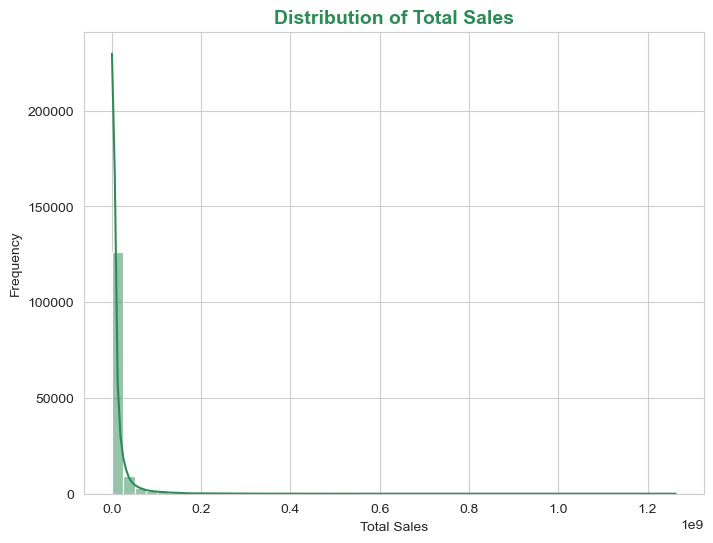

In [50]:
# Distribution of Total Sales
plt.figure(figsize=(8,6))
sns.histplot(df['total_sales'], bins=50, kde=True, color=main_green)
plt.title('Distribution of Total Sales', fontsize=14, fontweight='bold', color=main_green)
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()

Findings:
- The distribution is highly skewed to the right, indicating a few extremely high sales values while most transactions have lower sales.
- The majority of total sales are concentrated in the lower range, with a long tail showing a few extreme values.

Insights:
- ✅ Outliers exist, which could impact average-based statistics like mean revenue.
- ✅ Consider using log transformation or median-based measures for better analysis.
- ✅ Outlier detection and handling are crucial for accurate forecasting.

#### 2: Time-Series Analysis

Sales Trends Over Time: Identify patterns in total sales over time.
    
Seasonality Analysis: Detect weekly, monthly, and yearly variations.
    
Box Office Peaks: Identify peak seasons and blockbuster effects.

**Objective: Identify long-term trends, seasonality, and peaks in box office revenue.**

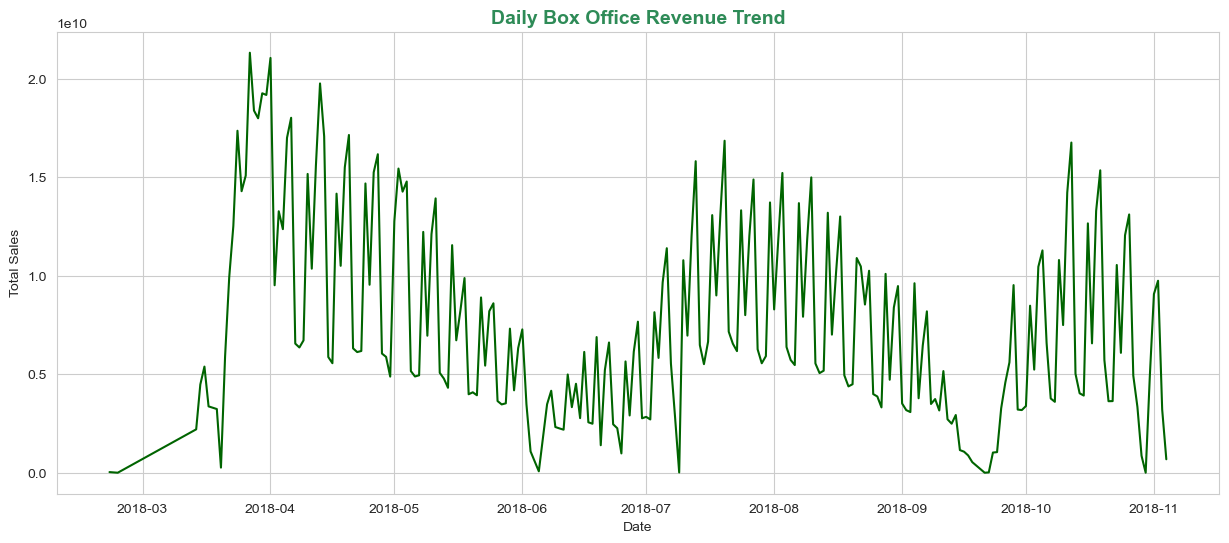

In [51]:
# Daily Box Office Revenue Trend
plt.figure(figsize=(15,6))
sns.lineplot(x=df.groupby('date').sum().index, y=df.groupby('date')['total_sales'].sum(), color=dark_green)
plt.title("Daily Box Office Revenue Trend", fontsize=14, fontweight='bold', color=main_green)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

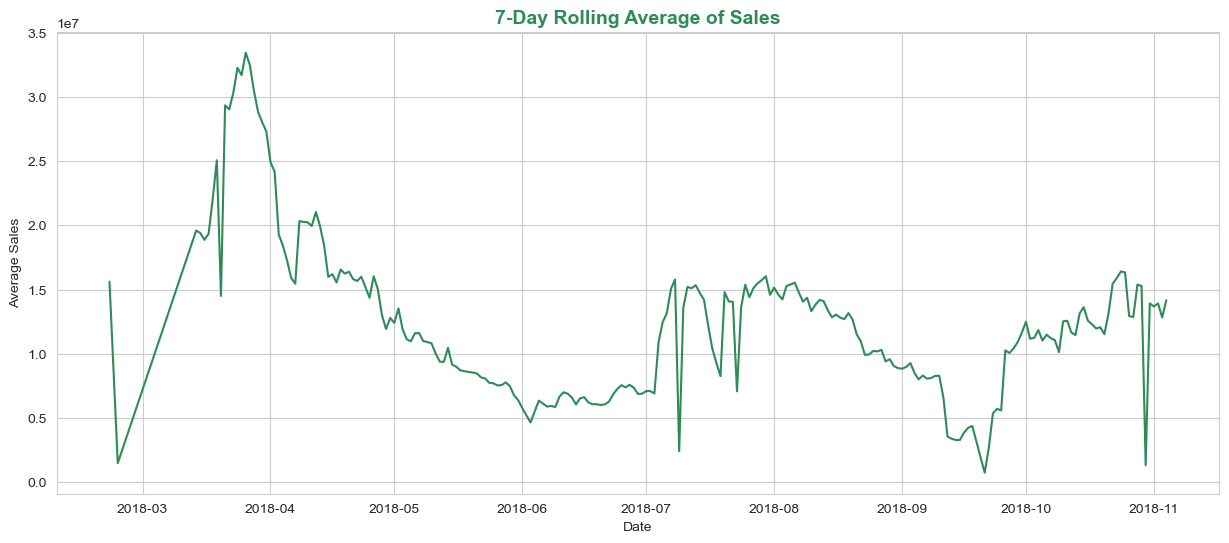

In [52]:
# Rolling Average (7-day moving)
df['rolling_sales'] = df.groupby("cinema_code")['total_sales'].transform(lambda x: x.rolling(7,1).mean())

plt.figure(figsize=(15,6))
sns.lineplot(x=df.groupby('date').sum().index, y=df.groupby('date')['rolling_sales'].mean(), color=main_green)
plt.title("7-Day Rolling Average of Sales", fontsize=14, fontweight='bold', color=main_green)
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.show()

Findings:
- The daily revenue fluctuates significantly, indicating possible seasonality or trends.
- A rolling 7-day average shows smoother trends, with noticeable peaks in certain months.

Insights:
- ✅ Identifying seasonal peaks is crucial—certain months or weeks may have consistently higher box office sales.
- ✅ Forecasting models should consider time-based patterns like holidays, weekends, and promotional events.

#### 3: Feature Correlations & Relationships

How do different factors impact revenue?

1. Price vs. sales: Do higher ticket prices lead to lower sales?
2. Occupancy vs. sales: Are higher occupancy rates linked to revenue?
3. Cinema size vs. performance: Do larger theaters perform better?

**Objective: Identify how different factors influence box office performance.**

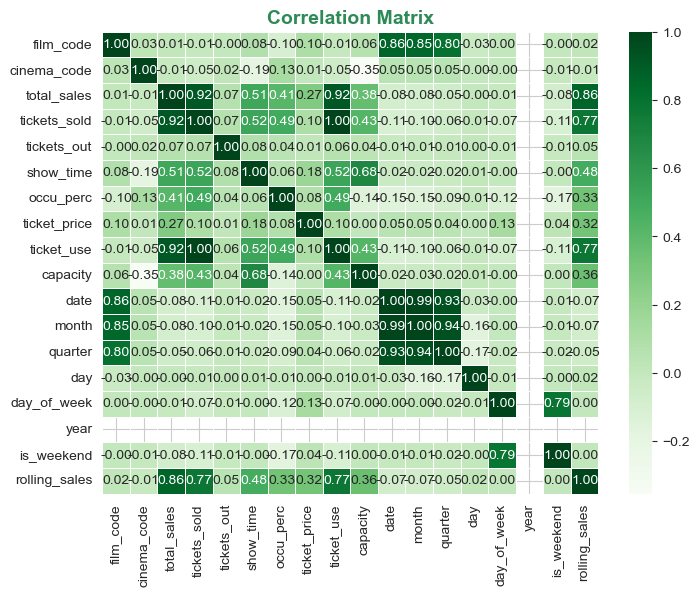

In [42]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="Greens", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14, fontweight='bold', color=main_green)
plt.show()

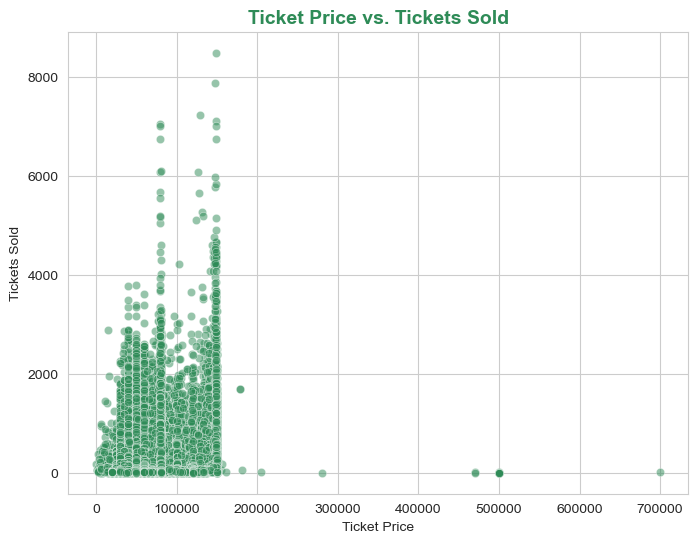

In [41]:
# Ticket Price vs. Tickets Sold
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["ticket_price"], y=df["tickets_sold"], alpha=0.5, color=main_green)
plt.title("Ticket Price vs. Tickets Sold", fontsize=14, fontweight='bold', color=main_green)
plt.xlabel("Ticket Price")
plt.ylabel("Tickets Sold")
plt.show()

Findings:
- Ticket sales and total sales are highly correlated (r > 0.9), which is expected.
- Ticket price has a weaker correlation with total sales, suggesting that pricing alone does not determine revenue.
- Occupancy rate (occu_perc) has a moderate positive correlation with revenue, indicating that theaters with higher occupancy tend to generate higher revenue.

Insights:
- ✅ Optimizing ticket prices may not directly boost revenue—strategies like discounts, promotions, or bundled offers could be explored.
- ✅ Capacity planning matters—understanding how occupancy affects revenue can help optimize showtimes and screenings.

#### 4. Cinema Performance Analysis

Which cinemas/movies are top performers?

**Objective: Identify top-performing cinemas**

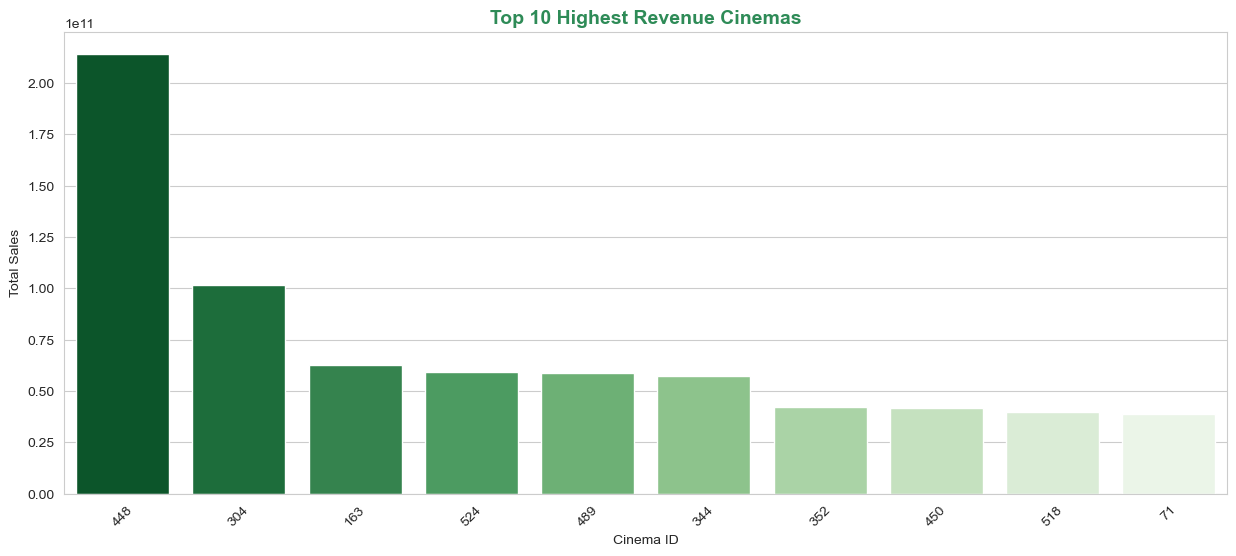

In [53]:
# Sales Per Cinema (Sorted by Total Sales)
plt.figure(figsize=(15,6))

# Get top 10 cinemas sorted by total sales
top_cinemas = df.groupby("cinema_code")["total_sales"].sum().nlargest(10)

# Convert to DataFrame and sort explicitly by total_sales
top_cinemas_df = top_cinemas.reset_index().sort_values(by="total_sales", ascending=False)

# Convert cinema_code to categorical with the correct sorting order
top_cinemas_df["cinema_code"] = top_cinemas_df["cinema_code"].astype(str)
top_cinemas_df["cinema_code"] = pd.Categorical(top_cinemas_df["cinema_code"], categories=top_cinemas_df["cinema_code"], ordered=True)

# Plot with correct sorting
sns.barplot(
    x=top_cinemas_df["cinema_code"], 
    y=top_cinemas_df["total_sales"], 
    palette=sns.color_palette("Greens_r", len(top_cinemas_df))
)

plt.title("Top 10 Highest Revenue Cinemas", fontsize=14, fontweight='bold', color="#2E8B57")
plt.xlabel("Cinema ID")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

Findings:
- The top 10 cinemas contribute significantly more revenue than others, showing clear performance disparity.
- Some cinemas have consistently high revenue, while others remain low.

Insights:
- ✅ Theaters vary significantly in revenue performance—some locations are high performers while others struggle.
- ✅ Data-driven location optimization can help identify profitable areas for new cinema openings or targeted marketing campaigns.

#### 5: Seasonal Trends & Weekday Effects

Are weekends busier than weekdays?


**Objective: Analyze revenue fluctuations based on time.**

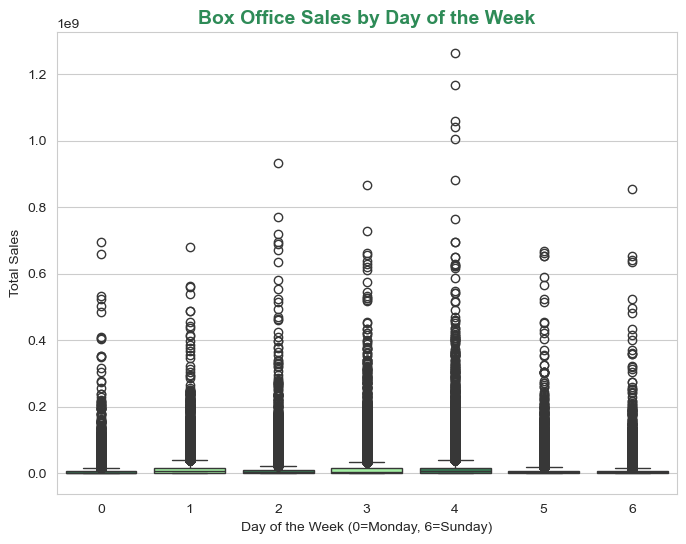

In [46]:
# Sales Distribution by Weekday
plt.figure(figsize=(8,6))
sns.boxplot(x=df["day_of_week"], y=df["total_sales"], palette=[main_green, light_green])
plt.title("Box Office Sales by Day of the Week", fontsize=14, fontweight='bold', color=main_green)
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Total Sales")
plt.show()

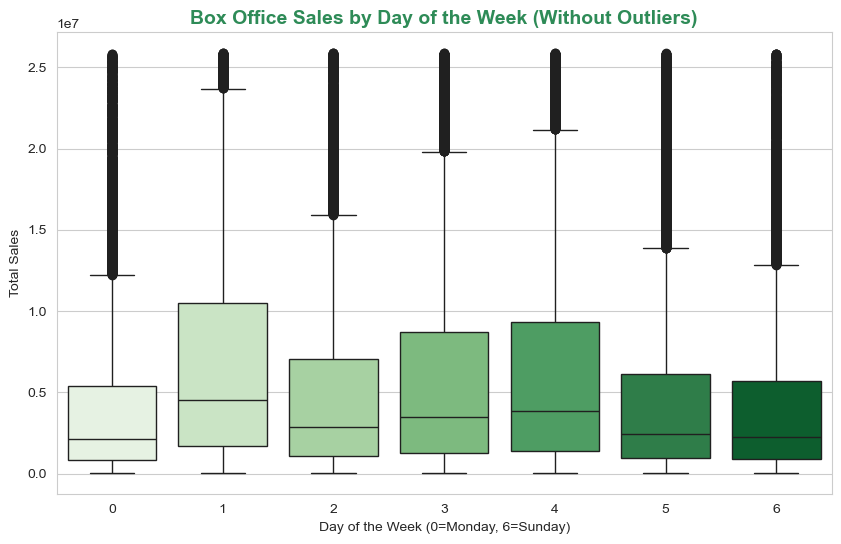

In [55]:
import numpy as np

# Compute IQR for outlier removal
Q1 = df["total_sales"].quantile(0.25)
Q3 = df["total_sales"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers
df_filtered = df[(df["total_sales"] >= lower_bound) & (df["total_sales"] <= upper_bound)]

# Plot boxplot without extreme outliers
plt.figure(figsize=(10,6))
sns.boxplot(x=df_filtered["day_of_week"], y=df_filtered["total_sales"], palette="Greens")

plt.title("Box Office Sales by Day of the Week (Without Outliers)", fontsize=14, fontweight='bold', color="#2E8B57")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Total Sales")
plt.show()


Findings:
- The median box office sales remain relatively stable across all days, with some variation.
- Higher variability is observed on weekends (Friday-Sunday), suggesting increased fluctuations in ticket sales.
- Outliers still exist, even after filtering, indicating occasional spikes in ticket revenue.

Insights:
- ✅ Weekend sales exhibit more variation, likely due to blockbuster releases, holidays, or promotions.
- ✅ Consistent midweek sales suggest a steady audience base, but with lower revenue potential.
- ✅ Tailored marketing strategies for weekdays vs. weekends can optimize revenue (e.g., weekday discounts, weekend premium pricing).
- ✅ Cinema scheduling should be adjusted based on demand patterns, possibly increasing showtimes on weekends and optimizing weekday screenings.